For U-net coding and training, i'm following this guide:<br>
https://medium.com/@vipul.sarode007/u-net-unleashed-a-step-by-step-guide-on-implementing-and-training-your-own-segmentation-model-in-a38741776968

## Part 1. Data loading and preparation

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# import sys
# sys.path.insert(1, '/kaggle/input/unetscratch')
from unet import unet

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate, Flatten, Dropout

1. Load images

In [2]:
image_dir = 'training/'
mask_dir = 'training-labels/'

imgsort = sorted(os.listdir(image_dir))
masksort = sorted(os.listdir(mask_dir))


In [3]:
len(imgsort), len(masksort)

(110, 110)

In [5]:
#loading the images, converting them to grayscale and resizing them to (256,256)
def load_images(imgsort, masksort, image_dir, mask_dir):
    images, masks = [], []

    for img, msk in tqdm(zip(imgsort, masksort), total = len(imgsort), desc = 'Loading Images and Masks'):
        image = cv2.imread(image_dir + img, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_dir + msk, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256,256))
        mask = cv2.resize(mask, (256,256))

#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        images.append(image)
        masks.append(mask)

        del image, mask

    return images, masks

images, masks = load_images(imgsort, masksort, image_dir, mask_dir)



Loading Images and Masks: 100%|██████████| 110/110 [00:00<00:00, 307.00it/s]


In [6]:
#Visualizing Images and Masks for Sanity
def plot_image_with_mask(image_list, mask_list, num_pairs = 4):
    plt.figure(figsize = (18,9))
    for i in range(num_pairs):
        idx = random.randint(0, len(image_list))
        img = image_list[idx]
        mask = mask_list[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(f'Real Image, index = {idx}')
        plt.axis('off')
        plt.subplot(2, 4, i + num_pairs + 1)
        plt.imshow(mask)
        plt.title(f'Segmented Image, index = {idx}')
        plt.axis('off')
        del img, mask

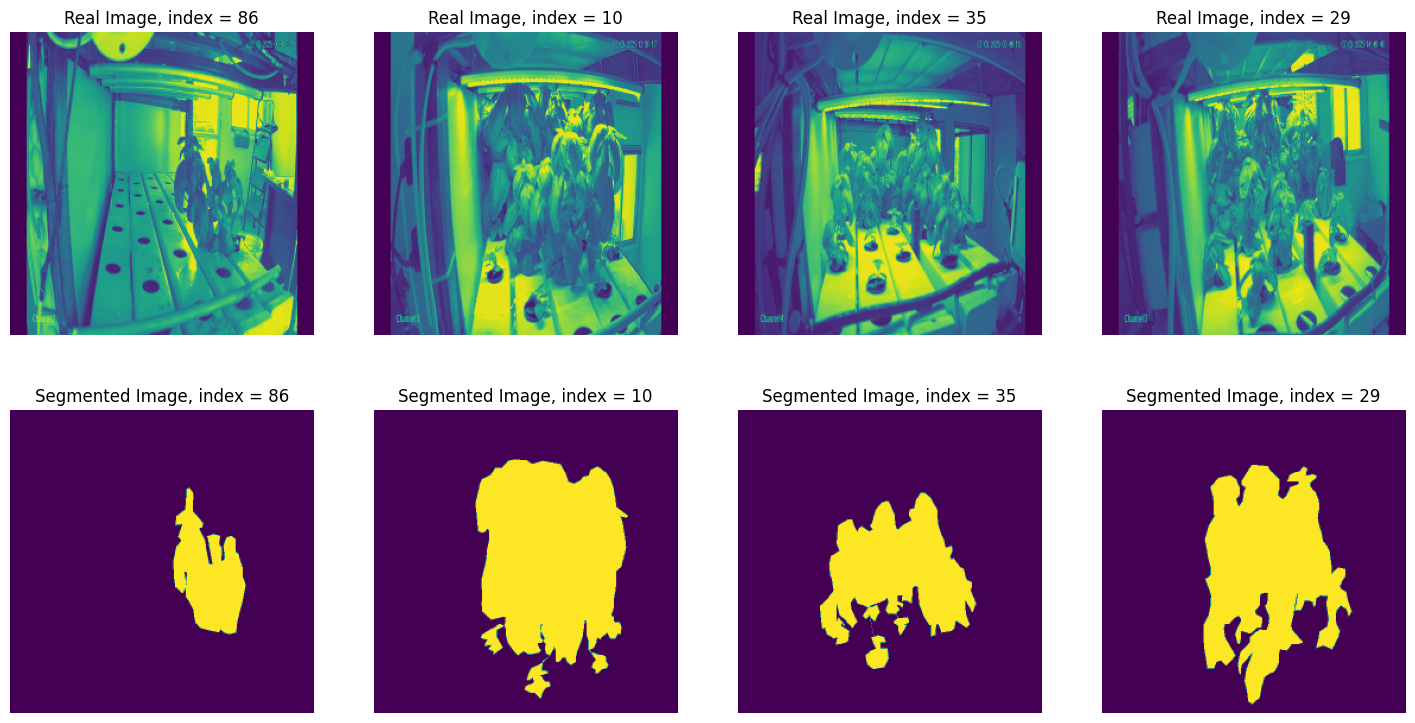

In [7]:
plot_image_with_mask(images, masks, num_pairs = 4)

2. Converting the images to tensors

In [8]:
def to_tensor(image_list, mask_list):
    tensor_images = tf.convert_to_tensor(tf.cast(np.array(image_list),  dtype = tf.float32))/255
    tensor_masks = tf.convert_to_tensor(tf.cast(np.array(mask_list), dtype= tf.float32))/255
    return tensor_images, tensor_masks

In [9]:
images, masks = to_tensor(images, masks)

3. Split into train test and validation

In [10]:
train_split = tf.cast(tf.round(len(images)*0.6) - 1, dtype = tf.int32)
test_val_split = tf.cast(tf.round(len(images)*0.2), dtype = tf.int32)

images_train = images[:train_split]
masks_train = masks[:train_split]

images_val = images[train_split:train_split + test_val_split]
masks_val = masks[train_split:train_split + test_val_split]

images_test = images[train_split + test_val_split:]
masks_test = masks[train_split + test_val_split:]

del images, masks

print(f'The length of images and masks for training is {len(images_train)} and {len(masks_train)} respectively')
print(f'The length of images and masks for validation is {len(images_val)} and {len(masks_val)} respectively')
print(f'The length of images and masks for testing is {len(images_test)} and {len(masks_test)} respectively')

The length of images and masks for training is 65 and 65 respectively
The length of images and masks for validation is 22 and 22 respectively
The length of images and masks for testing is 23 and 23 respectively


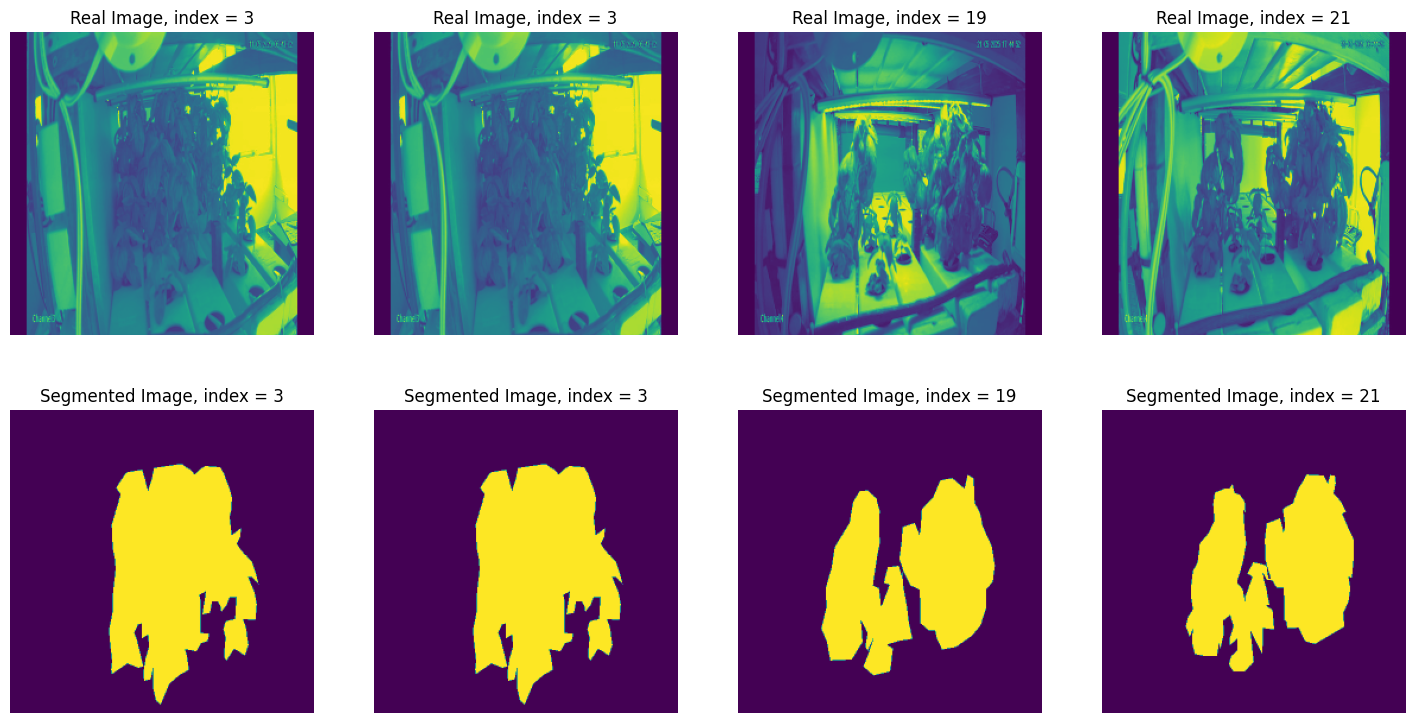

In [12]:
plot_image_with_mask(images_test, masks_test)

In [13]:
#Converting the list of tensors into batches to efficiently train the model, computation-wise
batch_size = 4

train_data = tf.data.Dataset.from_tensor_slices((images_train, masks_train))
train_data = train_data.batch(batch_size)

val_data = tf.data.Dataset.from_tensor_slices((images_val, masks_val))
val_data = val_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((images_test, masks_test))
test_data = test_data.batch(batch_size)

4. Evaluation metrics

In [20]:


# Setting dice coefficient to evaluate our model
# def dice_coeff(y_true, y_pred, smooth = 1):
#   intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
#   union = tf.reduce_sum(y_true, axis=-1) + tf.reduce_sum(y_pred, axis=-1)
#   dice_coeff = (2 * intersection + smooth) / (union + smooth)
#   return dice_coeff

def dice_coeff(y_true, y_pred, smooth=1):
    # Make sure y_true and y_pred have the same shape
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Reshape tensors if necessary (ensure both have same dimensions)
    if y_true.shape != y_pred.shape:
        # If y_pred has extra dimension, squeeze it
        if len(y_pred.shape) > len(y_true.shape):
            y_pred = tf.squeeze(y_pred, axis=-1)
        # If y_true has extra dimension, squeeze it
        elif len(y_true.shape) > len(y_pred.shape):
            y_true = tf.squeeze(y_true, axis=-1)

    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true, axis=-1) + tf.reduce_sum(y_pred, axis=-1)

    # Calculate dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice


In [21]:
#Allocating multiple gpus for training
strategy = tf.distribute.MirroredStrategy()

In [22]:

with strategy.scope():
    unet_model = unet()
    unet_model.compile(loss = 'binary_crossentropy',
            optimizer = 'adam',
            metrics = ['accuracy', dice_coeff])
unet_model.summary()



Model: "Unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 25,808,193 (98.45 MB)

 Trainable params: 25,808,193 (98.45 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:


#Defining early stopping to regularize the model and prevent overfitting
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)



In [24]:
#Training the model with 20 epochs (it will stop training in between because of early stopping)
unet_history = unet_model.fit(train_data, validation_data = [val_data],
                        epochs = 50, callbacks = [early_stopping])

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.6699 - dice_coeff: 0.2398 - loss: 0.6438 - val_accuracy: 0.8627 - val_dice_coeff: 0.1029 - val_loss: 0.4379
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7584 - dice_coeff: 0.1984 - loss: 0.5815 - val_accuracy: 0.8627 - val_dice_coeff: 0.1075 - val_loss: 0.3933
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.7584 - dice_coeff: 0.2001 - loss: 0.5406 - val_accuracy: 0.8627 - val_dice_coeff: 0.1419 - val_loss: 0.4187
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.7584 - dice_coeff: 0.2181 - loss: 0.5055 - val_accuracy: 0.8627 - val_dice_coeff: 0.1310 - val_loss: 0.3629
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.7584 - dice_coeff: 0.2247 - loss: 0.4909 - val_accuracy: 0.8627 - val_dice_coeff: 0.1306 - val_loss: 0.3520
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.7584 - dice_coeff: 0.2223 - loss: 0.4844 - val_accuracy: 0.8627 -

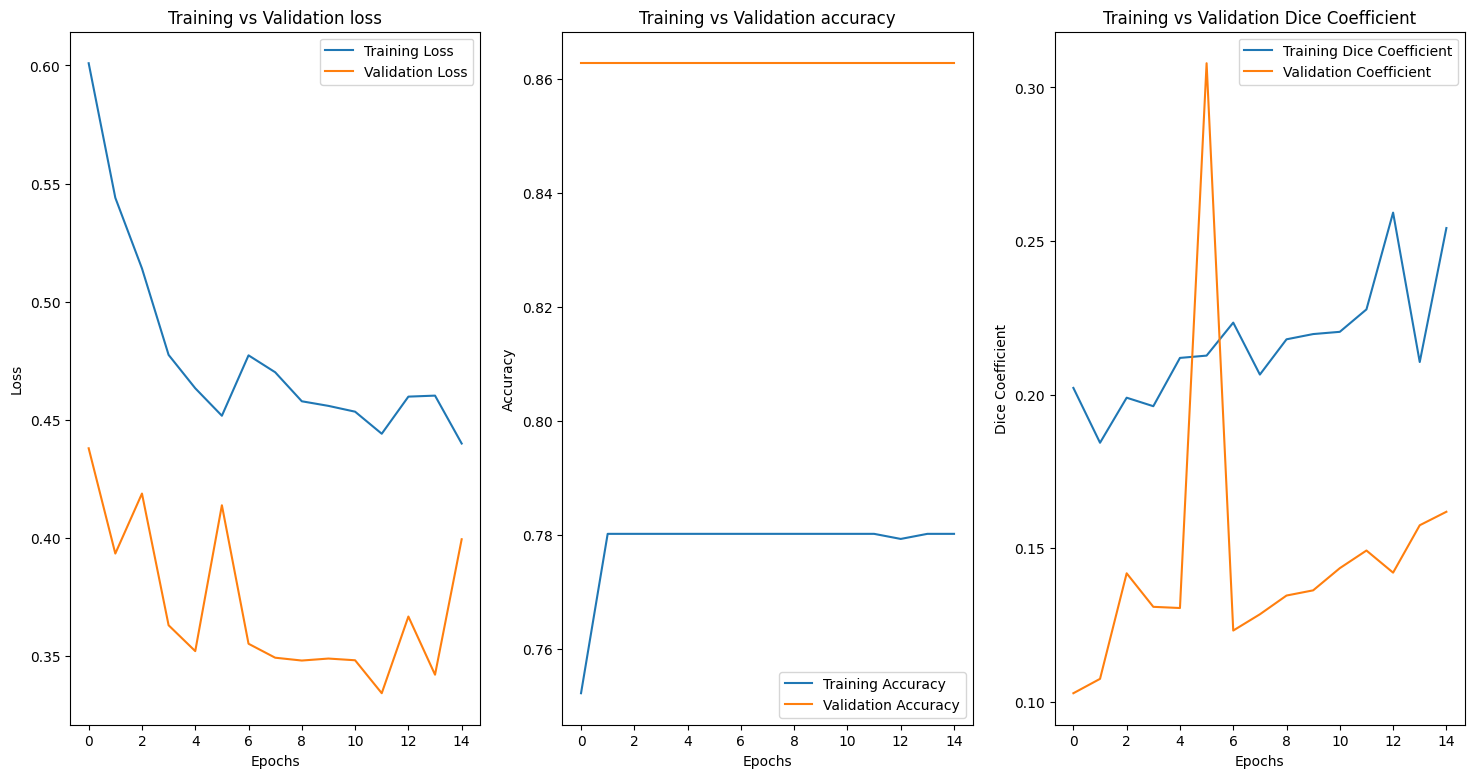

In [25]:


#Plotting the loss and accuracy during training and validation
plt.figure(figsize = (18, 9))
plt.subplot(1,3,1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.subplot(1,3,2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.title('Training vs Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.subplot(1,3,3)
plt.plot(unet_history.history['dice_coeff'])
plt.plot(unet_history.history['val_dice_coeff'])
plt.title('Training vs Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend(['Training Dice Coefficient', 'Validation Coefficient'])



In [27]:
unet_model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.7760 - dice_coeff: 0.2324 - loss: 0.4387


[0.4466370642185211, 0.7756818532943726, 0.2257833480834961]

In [44]:
def plot_preds(idx):
    plt.figure(figsize = (15, 15))
    test_img = images_test[idx]
    test_img = tf.expand_dims(test_img, axis = 0)
    test_img = tf.expand_dims(test_img, axis = -1)
    pred = unet_model.predict(test_img)
    pred = pred.squeeze()
    thresh = pred > 0.3
    plt.subplot(1,3,1)
    plt.imshow(images_test[idx])
    plt.title(f'Original Image {idx}')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks_test[idx])
    plt.title('Actual Mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(thresh)
    plt.title('Predicted Mask')
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


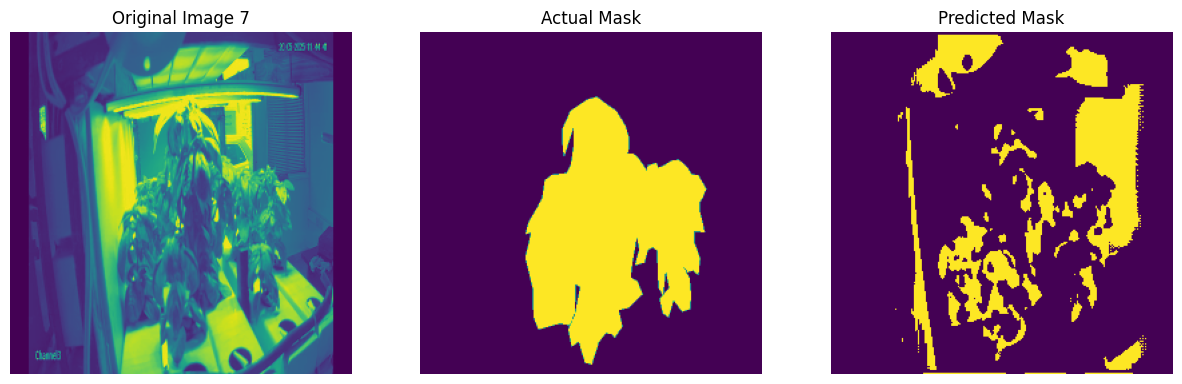

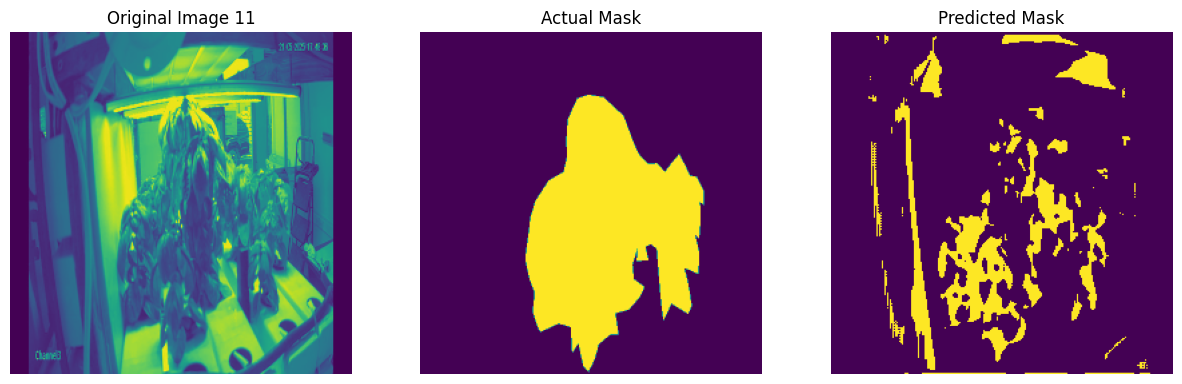

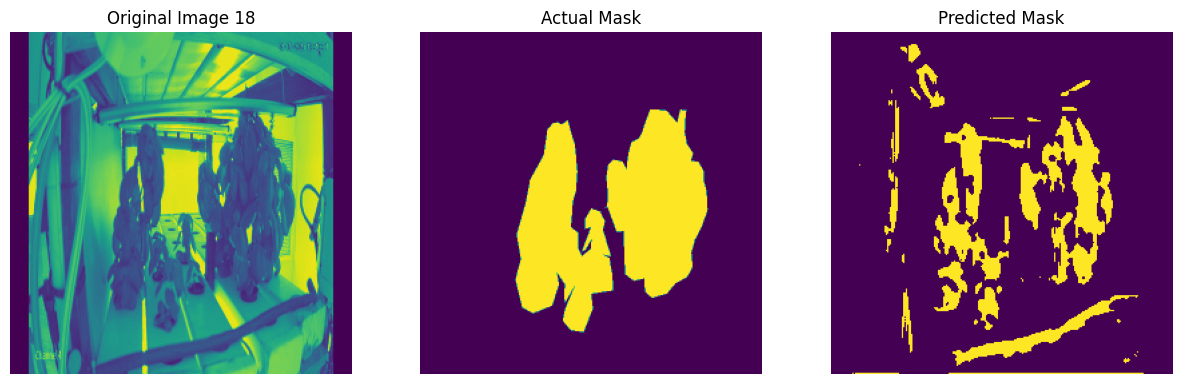

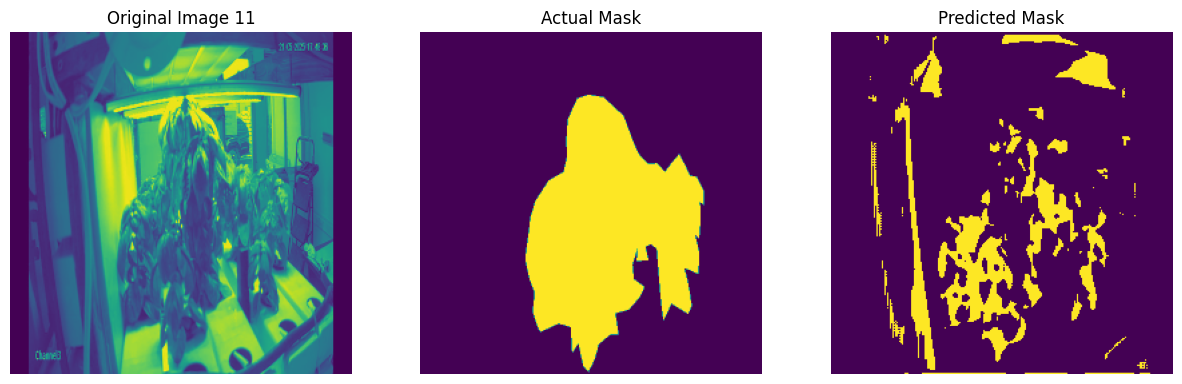

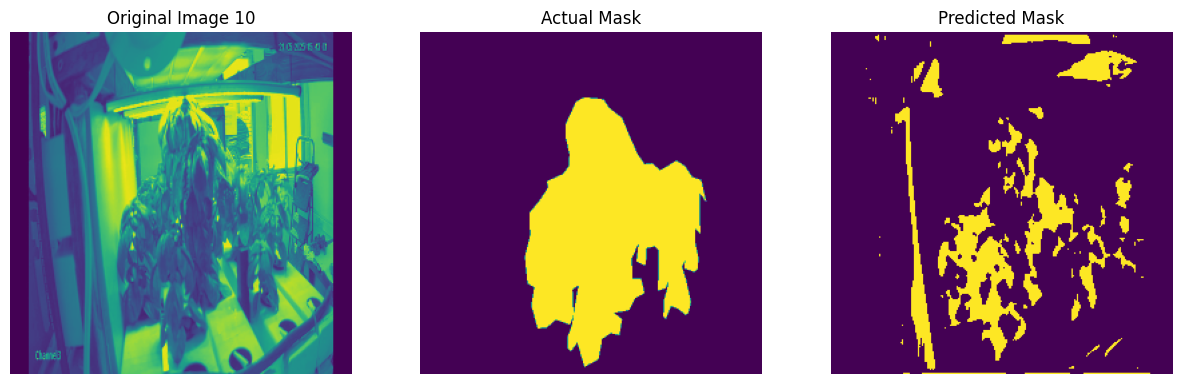

In [45]:
for i in [random.randint(0, 23) for i in range(5)]:
    plot_preds(i)

